In [1]:
from susy_qm.vqe_metrics import VQESummary
from susy_qm.vqe_plotter import VQEPlotter

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
cutoffs = [2, 4, 8, 16]#,128]
potentials = ["QHO","AHO","DW"]
#potentials = ["DW"]

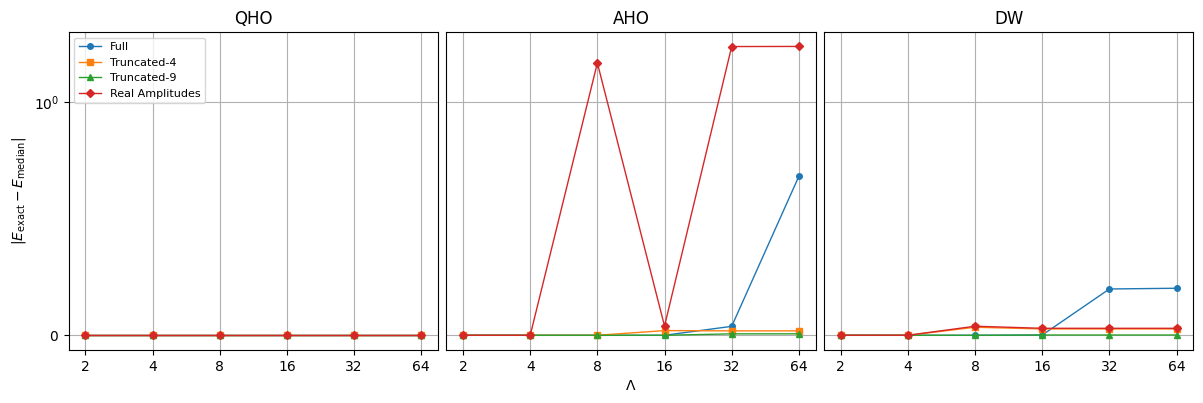

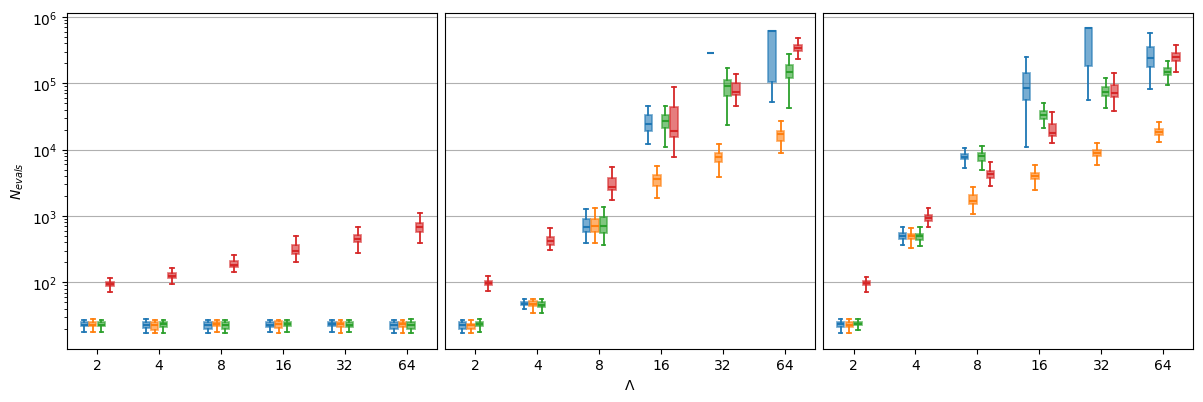

In [7]:
data_paths = [
    ("Full", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\None"),
    ("Truncated-4", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\TruncatedAnsatz\CQAVQE-Reduced4\None"),
    ("Truncated-9", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\TruncatedAnsatz\CQAVQE-Reduced9\None"),
    ("Real Amplitudes", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNP-RA\None"), 
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line(metric='median')

plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()

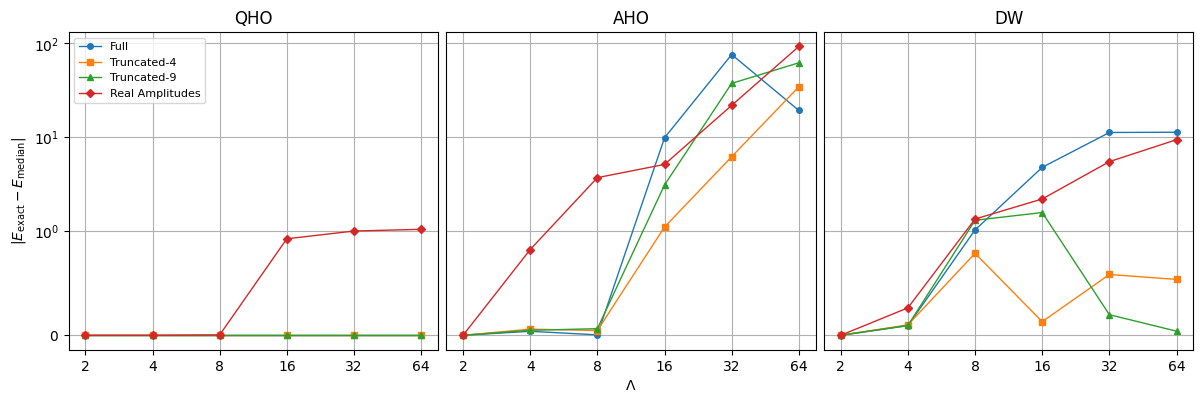

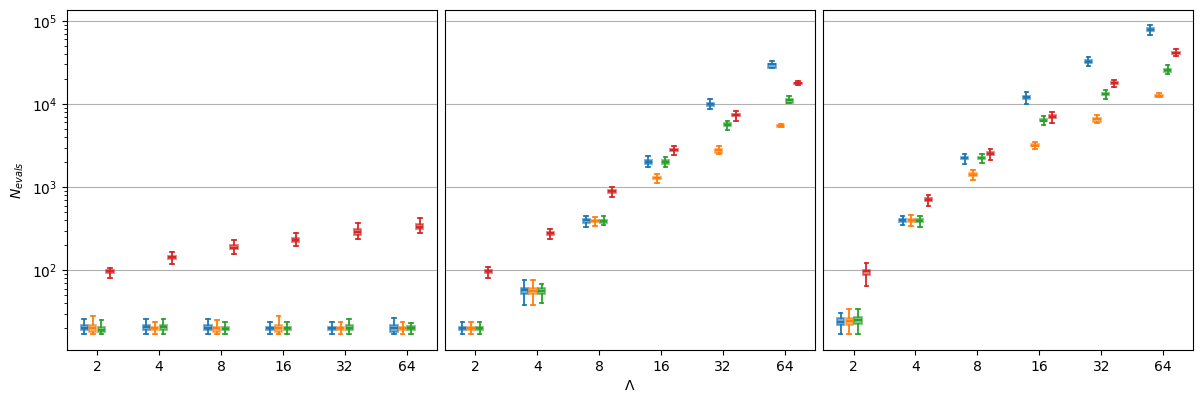

In [3]:
data_paths = [
    ("Full", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\10000"),
    ("Truncated-4", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\TruncatedAnsatz\CQAVQE-Reduced4\10000"),
    ("Truncated-9", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\TruncatedAnsatz\CQAVQE-Reduced9\10000"),
    ("Real Amplitudes", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNP-RA\10000"), 
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line(metric='median')

plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()

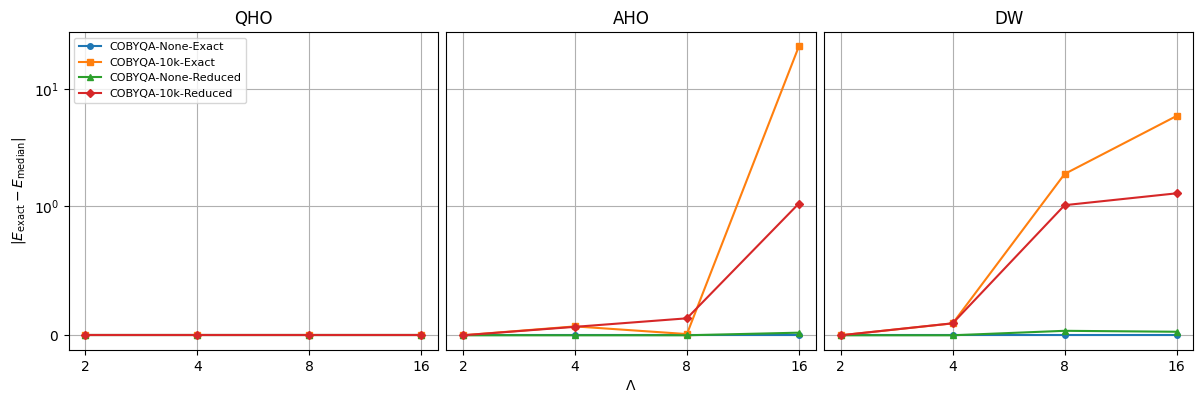

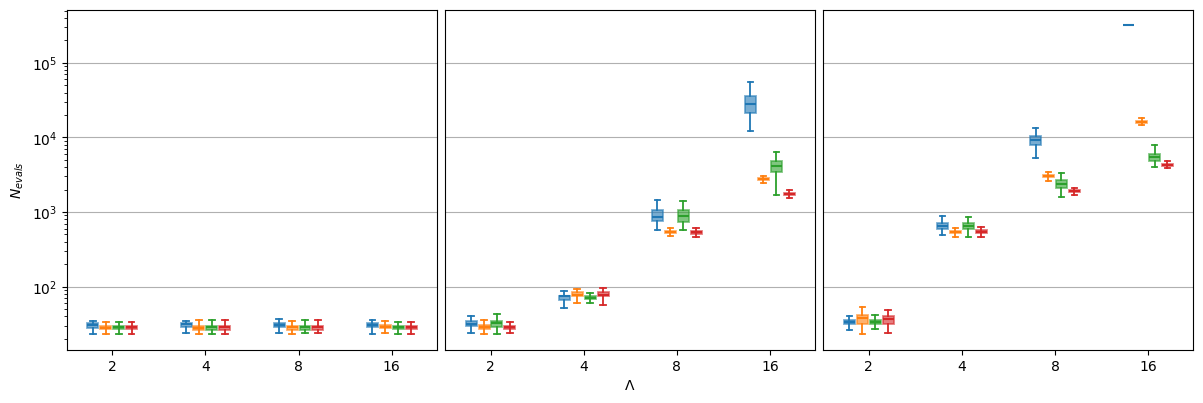

In [8]:
data_paths = [
    ("COBYQA-None-Exact", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\None"),
    ("COBYQA-10k-Exact", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\10000"),
    ("COBYQA-None-Reduced", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Reduced\None"),
    ("COBYQA-10k-Reduced", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Reduced\10000")
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line()
plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()

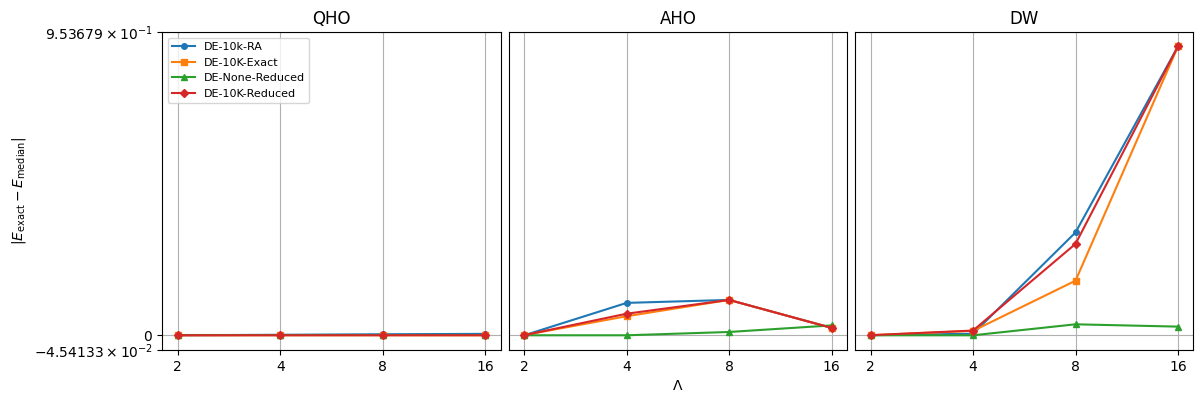

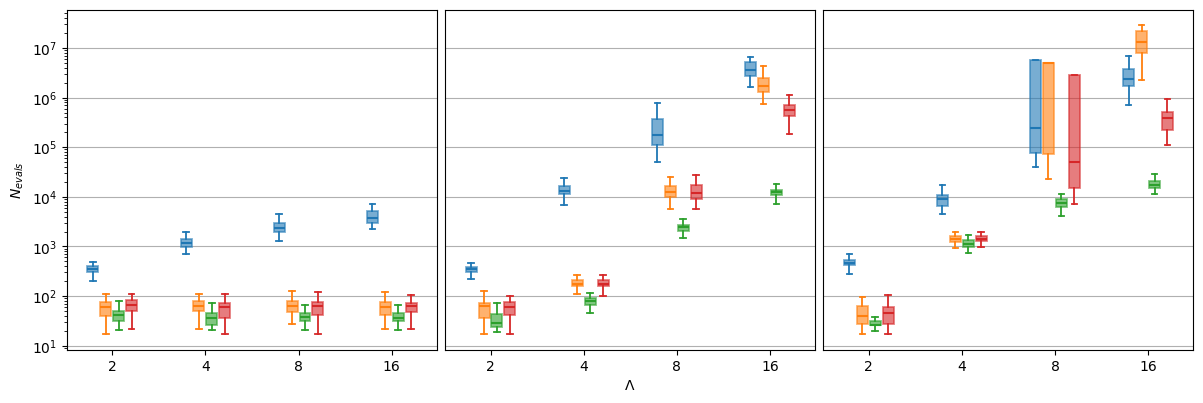

In [17]:
data_paths = [
    #("COBYQA-10k-Exact", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\10000"),
    #("COBYQA-10k-Reduced", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Reduced\10000"),
    #("COBYQA-None-Reduced", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Reduced\None"),
    ("DE-10k-RA", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesNP-RA2\10000"),
    #("DE-None-RA", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesNP-RA2\None"),
    #("DE-None-Exact", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\CQVQE-Exact\None"),
    ("DE-10K-Exact", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\CQVQE-Exact\10000"),
    ("DE-None-Reduced", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\CQVQE-Reduced\None"),
    ("DE-10K-Reduced", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\CQVQE-Reduced\10000")
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line()
plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()

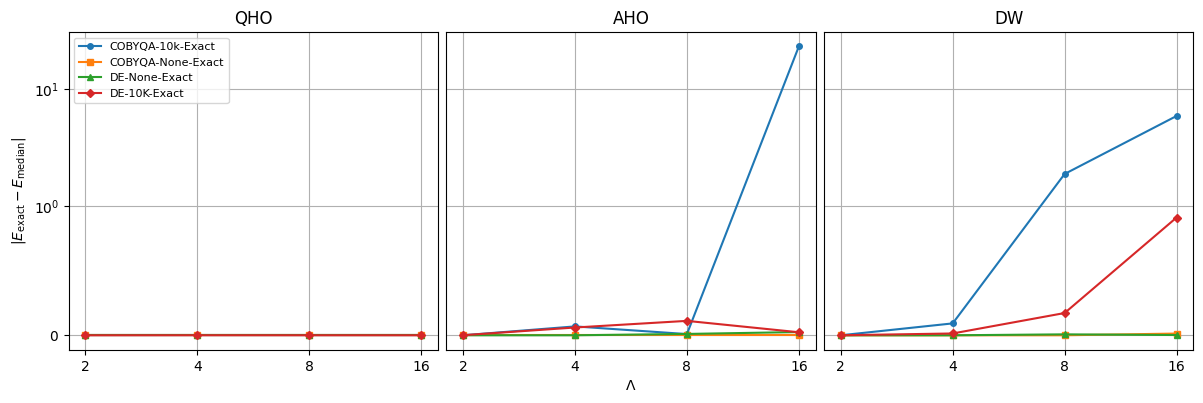

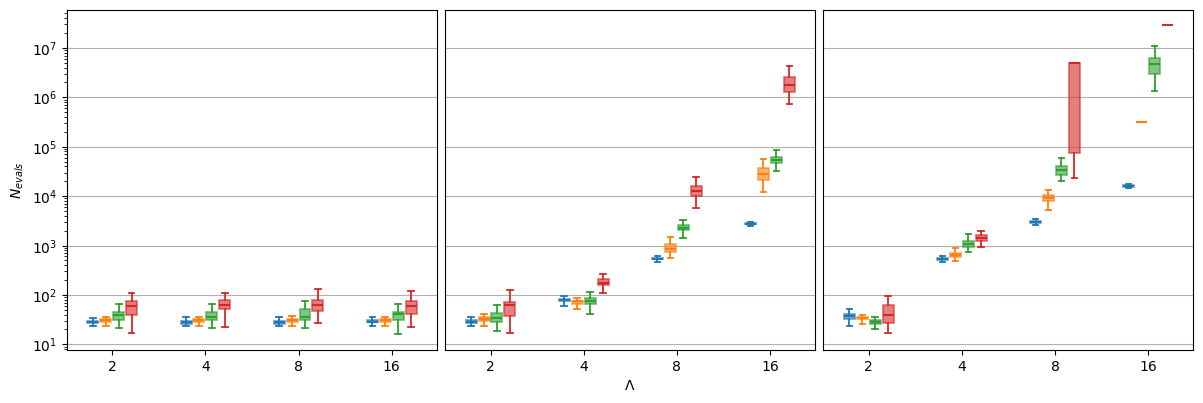

In [4]:
data_paths = [
    ("COBYQA-10k-Exact", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\10000"),
    ("COBYQA-None-Exact", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\None"),
    ("DE-None-Exact", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\CQVQE-Exact\None"),
    ("DE-10K-Exact", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\CQVQE-Exact\10000")
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line()
plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()

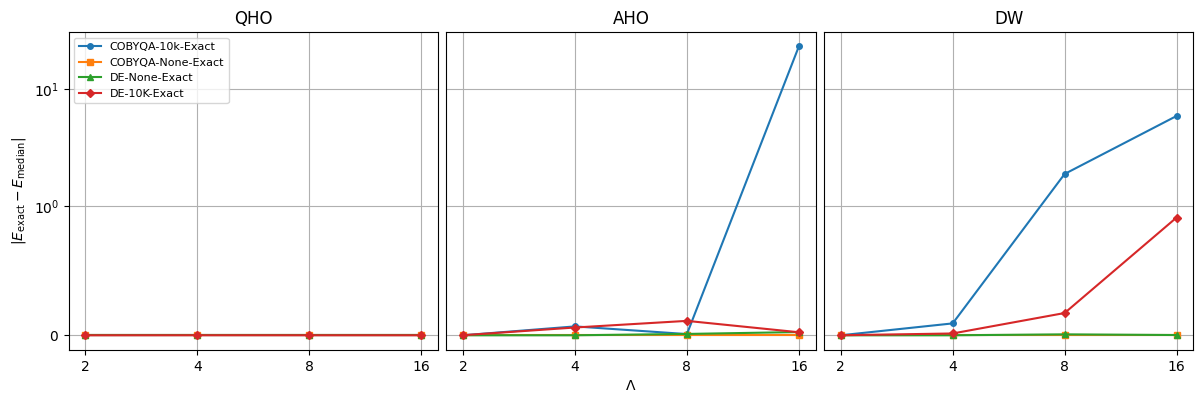

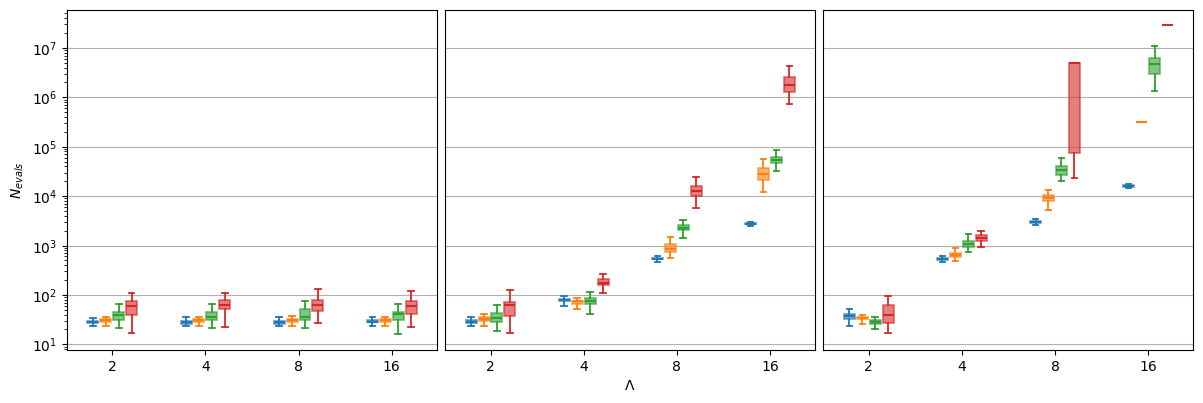

In [12]:
data_paths = [
    ("COBYQA-10k-Exact", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\10000"),
    ("COBYQA-None-Exact", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact\None"),
    ("DE-None-Exact", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\CQVQE-Exact\None"),
    ("DE-10K-Exact", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\CQVQE-Exact\10000")
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line()
plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()

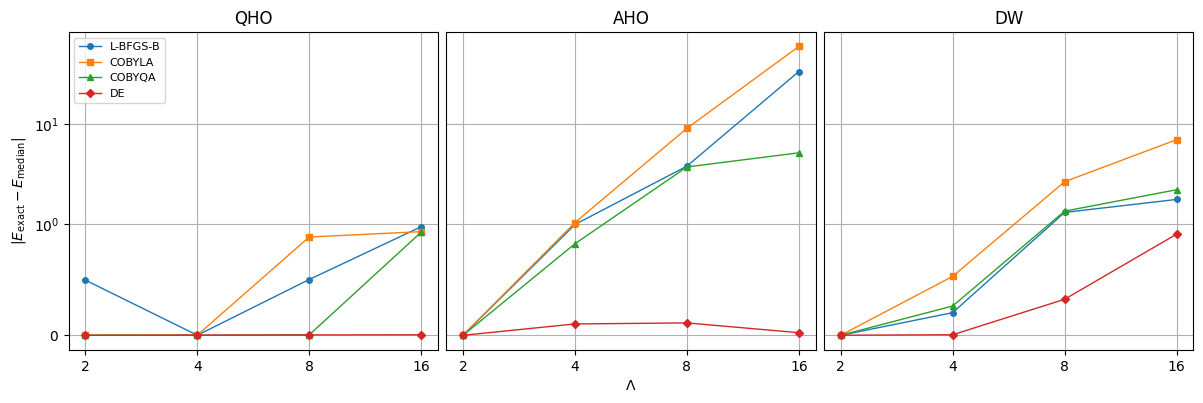

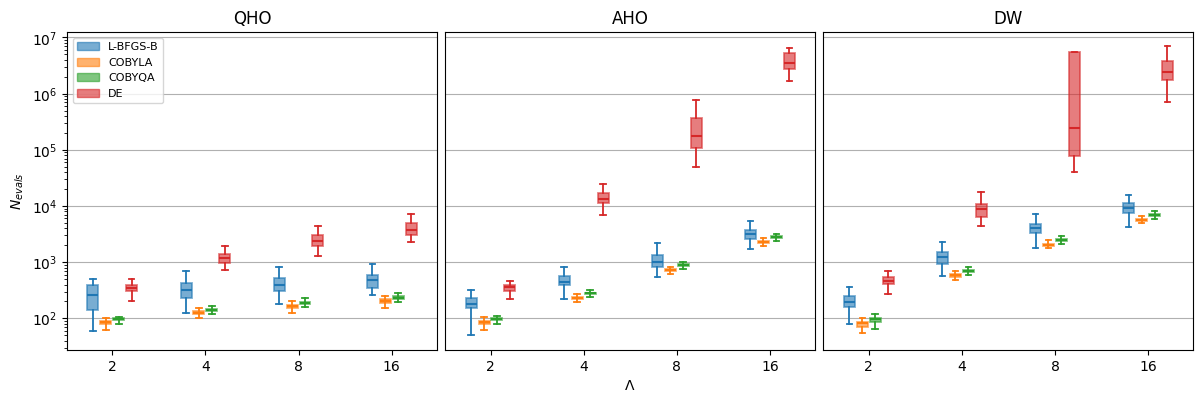

In [5]:
data_paths = [
    ("L-BFGS-B", r"SUSY\SUSY QM\PennyLane\L-BFGS-B\PauliDecomp\FilesNP-RA-ParamShift\10000"),
    ("COBYLA", r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\Real-Amplitudes\10000"),
    ("COBYQA", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNP-RA\10000"),
    ("DE", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesNP-RA2\10000")
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line()
plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=True, show_title=True)
plt.show()

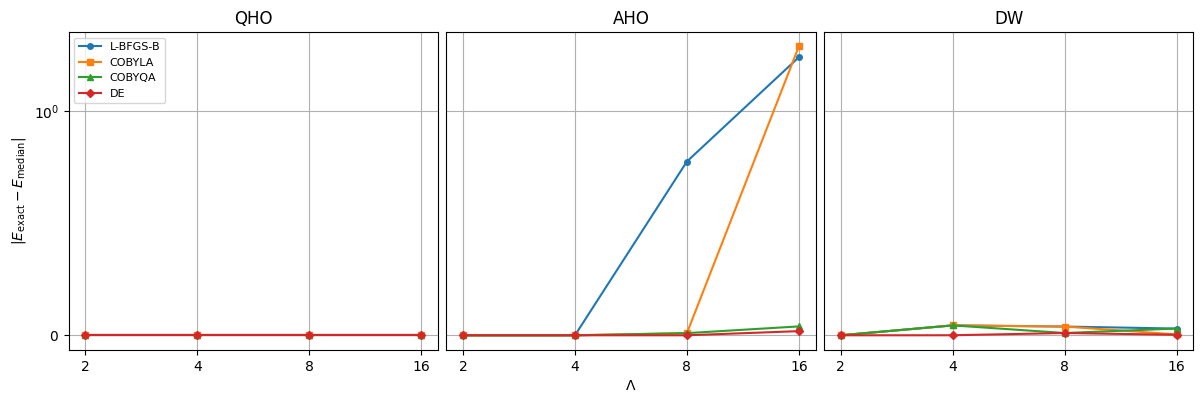

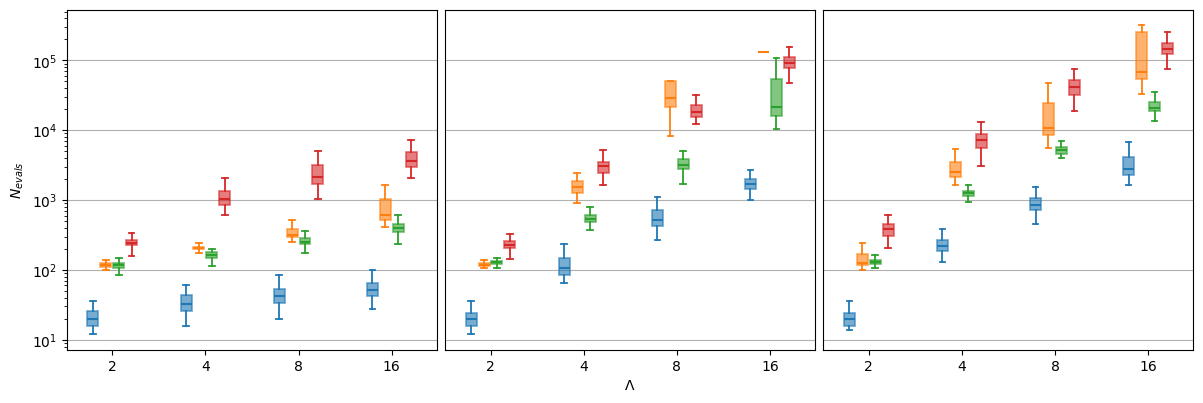

In [3]:
data_paths = [
    ("L-BFGS-B", r"SUSY\SUSY QM\PennyLane\L-BFGS-B\PauliDecomp\FilesNP-RA-ParamShift\None"),
    ("COBYLA", r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\Real-Amplitudes\None"),
    ("COBYQA", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNP-RA\None"),
    ("DE", r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesNP-RA2\None")
]

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line()
plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()

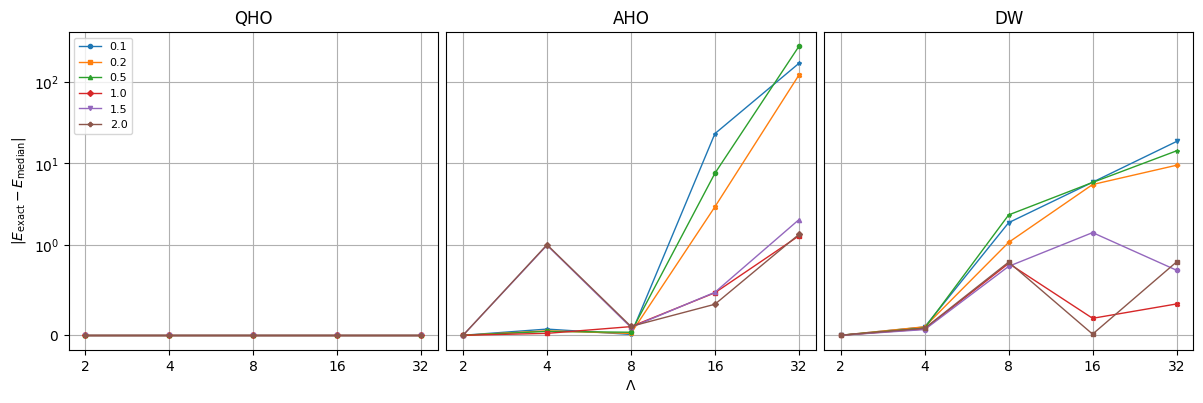

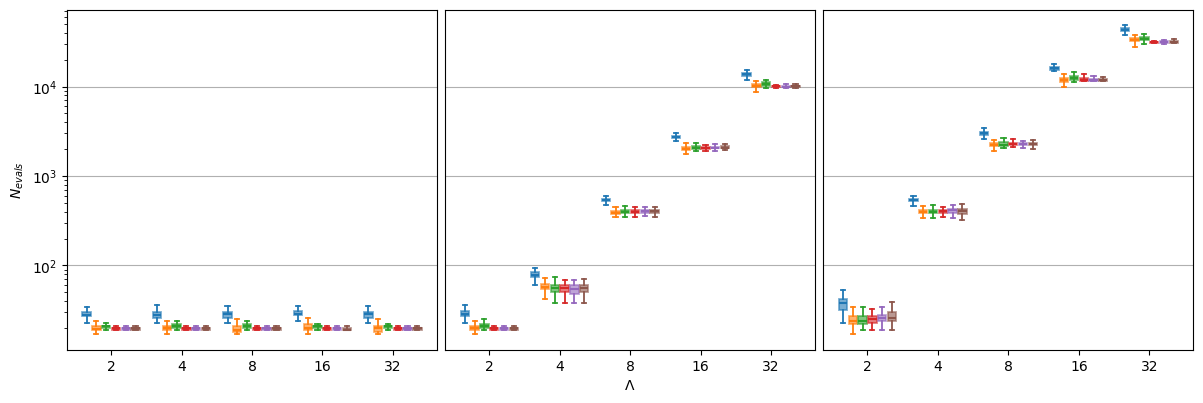

In [47]:
data_paths = []
folders = ['0.1', '0.2', '0.5', '1.0', '1.5', '2.0']

for f in folders:
    data_paths.append((f"{f}", r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\CQAVQE-Exact-VaryITR\{}\10000".format(f)))

plotter = VQEPlotter(data_paths, potentials, cutoffs)

plotter.plot_delta_e_vs_cutoff_line(linewidth=1.0, markersize=3.0, metric='median')
plt.show()

plotter.plot_evals_vs_cutoff_box(show_legend=False, show_title=False)
plt.show()